# Virtual Flow Meter using critical flow data at production choke
### Data and methodologies mentioned in reference below are reproduced here.
##### Reference: Barjouei, H.S., Ghorbani, H., Mohamadian, N. et al. Prediction performance advantages of deep machine learning algorithms for two-phase flow rates through wellhead chokes. J Petrol Explor Prod Technol 11, 1233–1261 (2021). https://link.springer.com/article/10.1007/s13202-021-01087-4 [Accessed 3 Jun 2021]


### Load Python Libraries

In [1]:
# Data storage, exploration
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data imputing
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# ML Model libraries

# The following three lines allow multiple and non-truncated outputs 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)

# Import Data & Preliminary Data Exploration
1. How many data records? 
2. How many variables / features or columns in each data record?
3. Peek at the first five records and the last five records

In [11]:
# Import Data
vfm = pd.read_csv(r"C:\Users\RajanChokshi\OneDrive - Accutant Solutions LLC\Accutant RC\Business\Training\2022\ALCE Training\ChokeFlow Example\SorushDatasetChokeFlow.csv")

In [12]:
vfm.info()
vfm.head()
vfm.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7245 entries, 0 to 7244
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sample #      7245 non-null   int64  
 1   Well          7245 non-null   object 
 2   D (1/64in)    7245 non-null   float64
 3   Pwh, Psig     7245 non-null   float64
 4   γo            7245 non-null   float64
 5   GLR, scf/STB  7245 non-null   int64  
 6   QL, STB/D     7245 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 396.3+ KB


,Sample #,Well,D (1/64in),"Pwh, Psig",γo,"GLR, scf/STB","QL, STB/D"
0,1,SR-17,71.424,175.930730,1.063251,152,10853.69614
1,2,SR-17,71.424,176.075768,1.063251,152,11019.74712
2,3,SR-17,71.424,174.915466,1.063251,152,11125.41593
3,4,SR-17,71.424,175.785692,1.063251,152,11110.32038
4,5,SR-17,71.424,175.205542,1.063251,152,11095.22484


,Sample #,Well,D (1/64in),"Pwh, Psig",γo,"GLR, scf/STB","QL, STB/D"
7240,7241,SR-26,41.216,440.624533,1.023322,118,6898.663608
7241,7242,SR-26,41.216,441.494759,1.023322,118,6913.759152
7242,7243,SR-26,41.216,442.655060,1.023322,118,6913.759152
7243,7244,SR-26,41.216,438.739042,1.023322,118,6913.759152
7244,7245,SR-26,41.216,439.754306,1.023322,118,6913.759152


## Statistics on each column / feature / variable
1. What are NaNs in the first five records for <b>chokegaslift</b>? There could be more in other records for this variable... and for other(s).
2. Review how many measurements for each variable in the <b>count</b> row. Why chokegaslift has less measurements? NaNs? How many? 
3. Review Mean, min, std dev and percentile values for each variable. 
    1. Could min-values be negative for <b>chokeprod, dhp</b>? 
    2. How about min-values being zero for certain variables?
    3. What are the median values?
4. What does it mean when 25% percentile-value is 0.0 for <b>dhp, gasliftpressure, dht</b> variables?

<Figure size 1080x432 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<AxesSubplot:>

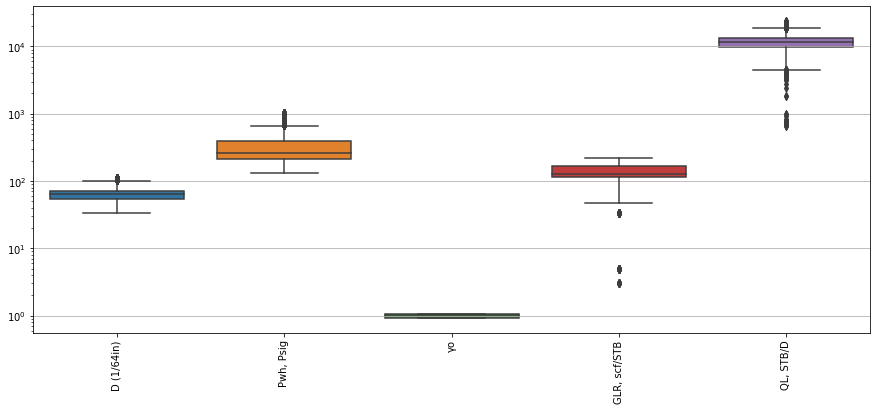

In [29]:
# plot statistics
plt.figure(figsize=(15,6));
plt.yscale("log");
plt.grid('y');
_ = plt.xticks(rotation='vertical');
sns.boxplot(data=vfm.drop(columns=['Sample #', 'Well']))

#### Boxplot Visualization
In the visualization above, why some boxes are very tall (long color bars).
1. Which variable has the smallest distribution?
2. Which variable is widely distributed?
3. What does it mean when one whisker is longer than the other?

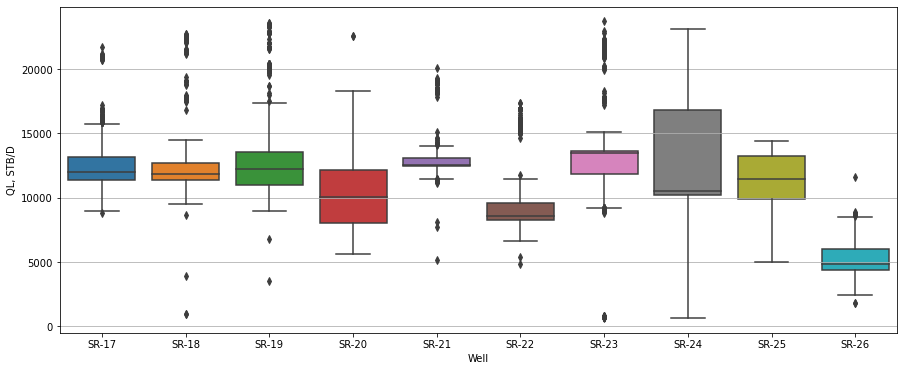

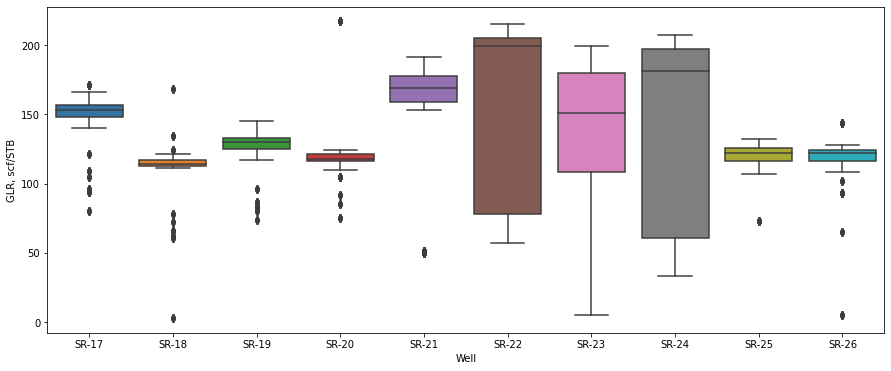

In [30]:
plt.figure(figsize=(15,6));
plt.grid('y');
sns.boxplot(data=vfm, x="Well", y="QL, STB/D");
plt.figure(figsize=(15,6));
sns.boxplot(data=vfm, x="Well", y="GLR, scf/STB");

### Histograms
Help visualize how measurements are distributed.
Wouldn't we like them to be normally distributed?!?

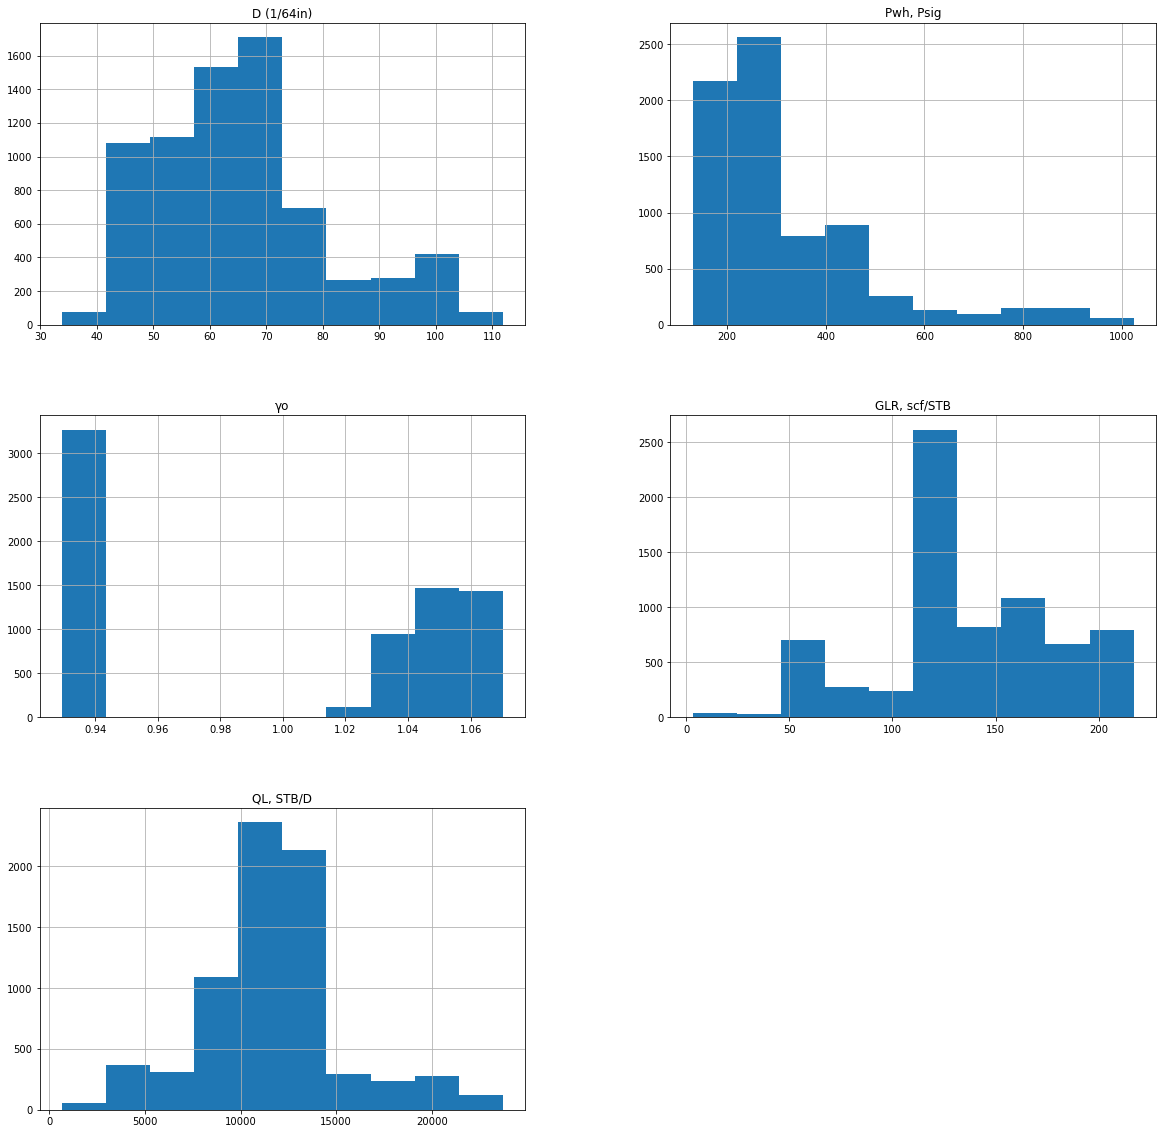

In [28]:
vfm.drop(columns=['Sample #']).hist(figsize=(20, 20));

In [31]:
vfm.columns

Index(['Sample #', 'Well', 'D (1/64in)', 'Pwh, Psig', 'γo', 'GLR, scf/STB',
       'QL, STB/D'],
      dtype='object')

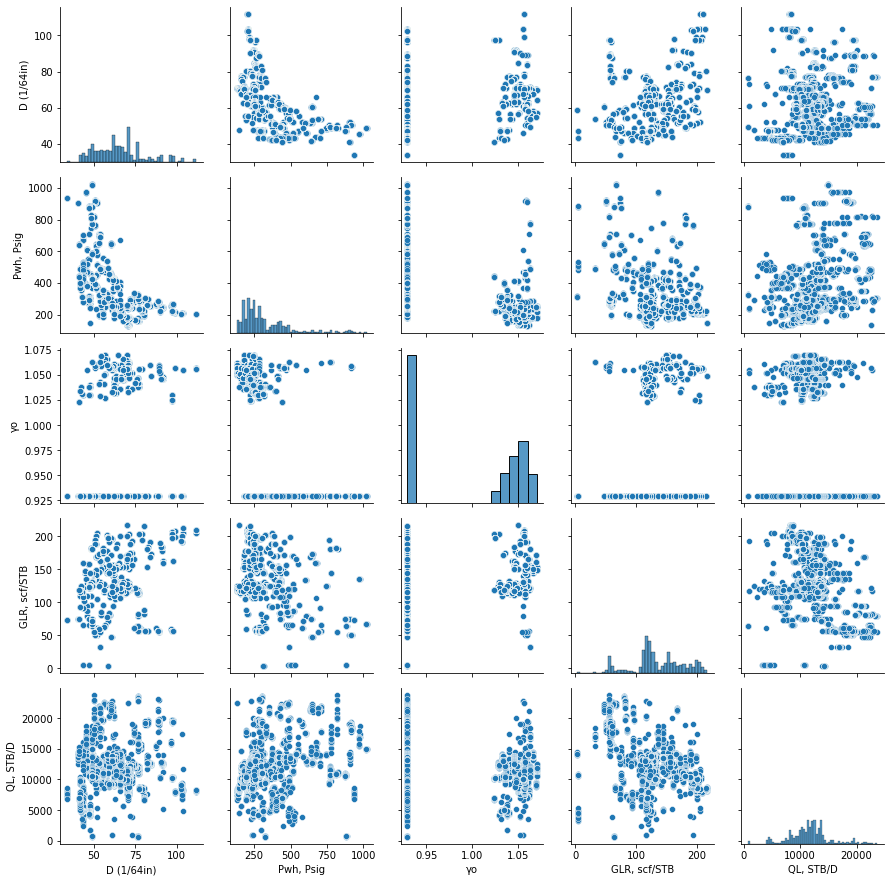

In [32]:
plot_vars = ['D (1/64in)', 'Pwh, Psig', 'γo', 'GLR, scf/STB', 'QL, STB/D']
# Define a function to plot histogram and scatterplot for the specified variables/columns of provided dataframe 
def plotPairgrid(df, plot_vars):
    g = sns.PairGrid(data=df, vars=plot_vars);
    g.map_diag(sns.histplot);
    g.map_offdiag(sns.scatterplot);

plotPairgrid(vfm, plot_vars);

### Correlations between Variables
Let's find out if two variables are correlated by calculating correlation coefficients between two variables. 
1. Positive value (positive correlation) means one increases with another in the dataset; and 
2. Negative value (negative correlation) means one decreases while another increases and vice versa. 
3. Magnitude of the correlation coefficient indicates strength of the correlation.

#### Why do we want to perform this exercise?

,D (1/64in),"Pwh, Psig",γo,"GLR, scf/STB","QL, STB/D"
D (1/64in),1.000000,-0.539999,0.216265,0.294505,0.060906
"Pwh, Psig",-0.539999,1.000000,-0.451719,-0.237796,0.272472
γo,0.216265,-0.451719,1.000000,0.221793,-0.278525
"GLR, scf/STB",0.294505,-0.237796,0.221793,1.000000,-0.363745
"QL, STB/D",0.060906,0.272472,-0.278525,-0.363745,1.000000


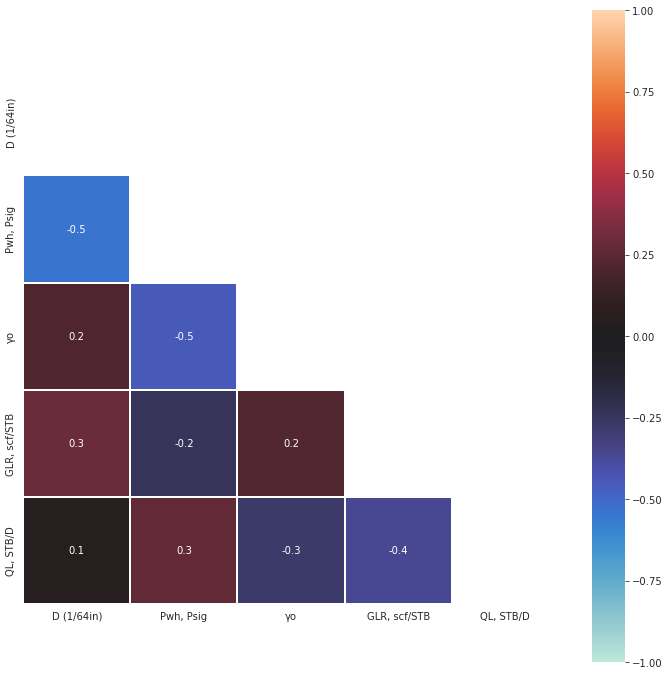

In [34]:
corr = vfm[plot_vars].corr()
corr

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask, center=0.0, linewidths=0.1, annot=True, 
                     square=True, vmin=-1., vmax=1., fmt='3.1f')

# Data Exploration
### Missing Data at Macro Level
Are there any null (NaN) measurements for numeric data columns?

In [36]:
# Q1. How many nulls are there?
vfm.isnull().sum()

# Q2. How many values are zero or -ve
(vfm[plot_vars] <= 0.0).sum()

Sample #        0
Well            0
D (1/64in)      0
Pwh, Psig       0
γo              0
GLR, scf/STB    0
QL, STB/D       0
dtype: int64

D (1/64in)      0
Pwh, Psig       0
γo              0
GLR, scf/STB    0
QL, STB/D       0
dtype: int64

### Prepare features and target data arrays 
Also separate in training and test sets

In [68]:
# Separate targets from inputs
target= ['QL, STB/D']

y = vfm[target].values.ravel()
X = vfm[plot_vars].drop(columns=target).to_numpy()

In [70]:
# Do we have nulls in targets and inputs?
np.isnan(y).any(), np.isnan(X).any()
y.shape, X.shape

(False, False)

((7245,), (7245, 4))

In [91]:
# Normalize all the samples between [-1, +1]
X = (X- X.min(axis=0))/(X.max(axis=0) - X.min(axis=0))*2 - 1

In [93]:
X[:5]

array([[-0.03606557, -0.89832711,  0.89974937,  0.39252336],
       [-0.03606557, -0.89800227,  0.89974937,  0.39252336],
       [-0.03606557, -0.90060094,  0.89974937,  0.39252336],
       [-0.03606557, -0.89865194,  0.89974937,  0.39252336],
       [-0.03606557, -0.89995127,  0.89974937,  0.39252336]])

In [94]:
## Sub-divide datatest into training and testing: 80 - 20% split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, random_state=1002)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def calc_predMetrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return [rmse, mape, r2]
    
from sklearn.model_selection import cross_val_score

In [97]:
#  In this study, the RBF kernel is used with the SVR algorithm 
# to predict two-phase flow rate (Ql) through a wellhead choke.
from sklearn.svm import SVR
svr_rbf = SVR(kernel="rbf", C=100000, gamma=0.05, epsilon=0.1)
y_pred_svr = svr_rbf.fit(X_train, y_train).predict(X_test)
svr_rbf_metric = {"svr_rbf":calc_predMetrics(y_test, y_pred_svr)}
svr_rbf_metric

{'svr_rbf': [2724.767546585346, 0.40714028477516334, 0.4451171576093189]}